# 1. Configuration

In [1]:
import pandas as pd

In [2]:
raw_df = pd.read_csv('data/april-data.csv')

print(len(raw_df))
raw_df.head()

1007


,Id,Date/Time Requested,Giveaway title,Customer Name,Email_address,School_name,Postal_address,Address_line_2,Address_city,Postcode,Additional_info
0,312781,4/1/25 8:08,April Community Collection: Gardening Bundle G...,Kate Thompson,kate.thompson@fhhschools.com,Fountain Head House School,Church Road,NaN,Saltash,PL12 4AE,In our school we have an Outdoors Instructor w...
1,312783,4/1/25 8:32,April Community Collection: Gardening Bundle G...,Shona Wilson,shonaedment1994@gmail.com,S4YC @ Little Owls,Gadbrook Road,NaN,Northwich,CW9 7JL,We are currently working on our outdoor provis...
2,312790,4/1/25 9:22,April Community Collection: Gardening Bundle G...,Charlotte Coldham-Wood,daveandcharwood@gmail.com,Archbishop Benson School,Archbishop Benson School,Bodmin Road,Truro,TR1 1BN,"I would use this bundle with our SEN children,..."
3,312801,4/1/25 10:37,April Community Collection: Gardening Bundle G...,Erica Bowen,erica.bowen@thewillowseyc.org.uk,The Willows School,Fishermead Boulevard,Fishermead,Milton Keynes,mk6 2lp,"I run outdoor learning at my school, we are in..."
4,312802,4/1/25 10:42,April Community Collection: Gardening Bundle G...,Amy Smith,amysmith@ourladyofgracercprimaryschool.co.uk,Our Lady of Grace RC Primary School,Highfield road,Prestwich,Bury,m25 0as,Our school is passionate about hands-on learni...


In [3]:
raw_df.columns = raw_df.columns.str.lower().str.replace(' ','_')

raw_df.columns

Index(['id', 'date/time_requested', 'giveaway_title', 'customer_name',
       'email_address', 'school_name', 'postal_address', 'address_line_2',
       'address_city', 'postcode', 'additional_info'],
      dtype='object')

In [4]:
raw_df.rename(columns={'date/time_requested':'date'}, inplace=True)

raw_df.columns

Index(['id', 'date', 'giveaway_title', 'customer_name', 'email_address',
       'school_name', 'postal_address', 'address_line_2', 'address_city',
       'postcode', 'additional_info'],
      dtype='object')

In [5]:
df = raw_df.copy()

In [6]:
texts = df['additional_info'].to_list()

# 2. Extracting Product Mentions

## 2.1  Named Entity Recognition

Here we'll test out if NER is the best approach for this task

In [7]:
import spacy

nlp = spacy.load('en_core_web_md')

In [8]:
# The code below let's us see what named entities are available on the pre-trained model

In [9]:
ner_labels = nlp.get_pipe('ner').labels
print(ner_labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


In [10]:
docs = [nlp(text) for text  in texts if isinstance(text, str)]

In [11]:
for doc in docs:
    entities = []
    for ent in doc.ents:
        if ent.label_ in "PRODUCT":
            entities.append((ent.text, ent.label_))

    print("APP:", {doc})
    print("")
    print(f"{entities}")
    print('-'*30)

APP: {In our school we have an Outdoors Instructor who would love the chance to develop a veg patch in her outdoor space to support our SEND students in growing and cooking their own food. The equipment and seeds provided in the giveaway would develop our students understanding of how to grow your own food but also the process of growing your own food.}

[]
------------------------------
APP: {We are currently working on our outdoor provision. We have a large area and would love to be able to give it a full makeover! As a setting our ethos is to be nature inspired whilst using the curiosity approach with the added extras of colour etc. The children love spending time in the garden and enjoy planting and tending for the plants whilst also looking at the nature around. We have a wildlife garden which is in great need for a massive do over due to it being overgrown also - in here we have a pond, which was once home to many frogs!}

[]
------------------------------
APP: {I would use this 

### Outcome

Named entity really works best for when we're trying to extract proper names from elements in text. For example, above, you can see that it isn't Nouns that are considered products (_scissors, chairs, books_) but rather names.

## 2.2 Noun Phrase Extraction

In [12]:
nlp = spacy.load('en_core_web_md')

In [13]:
docs = [nlp(text) for text in texts[:10] if isinstance(text, str)]

In [14]:
doc_noun_phrases = {}

for idx, doc in enumerate(docs):
    noun_phrases = [chunk.text for chunk in doc.noun_chunks]
    doc_noun_phrases[f'Document_{idx+1}'] = noun_phrases
    
for doc_id, noun_phrases in doc_noun_phrases.items():
    print(f"{doc_id}:")
    for np in noun_phrases:
        print(f"  - {np}")

Document_1:
  - our school
  - we
  - an Outdoors Instructor
  - who
  - the chance
  - a veg patch
  - her outdoor space
  - our SEND students
  - their own food
  - The equipment
  - seeds
  - the giveaway
  - our students
  - understanding
  - your own food
  - the process
  - your own food
Document_2:
  - We
  - our outdoor provision
  - We
  - a large area
  - it
  - a full makeover
  - a setting
  - our ethos
  - nature
  - the curiosity approach
  - the added extras
  - The children
  - spending time
  - the garden
  - the plants
  - the nature
  - We
  - a wildlife garden
  - which
  - great need
  - a massive do
  - it
  - we
  - a pond
  - which
  - many frogs
Document_3:
  - I
  - this bundle
  - our SEN children
  - I
  - who
  - trauma
  - gardening
  - huge therapeutic benefits
  - this bundle
  - me
  - the children
  - the garden
  - the natural dopamine rush
Document_4:
  - I
  - outdoor learning
  - my school
  - we
  - a very deprived area
  - a central area
  - Milt

### Learnings

These are still waaay too broad.

## 2.3 AI

In [15]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.2
)

In [16]:
llm.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_80cf447eee', 'finish_reason': 'stop', 'logprobs': None}, id='run-31385b0b-6e78-4a5f-b3b0-d10d7892797f-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [17]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
        """
        You are a data extraction assistant helping a grant review team evaluate funding applications from schools. Your task is to extract a structured list of specific items or services that the school is requesting funding for.
        
        ## Instructions:

        - Users will submit excerpts from grant application letters.
        - From each letter, extract only the tangible items or clearly defined services the school wants to use the grant for.
        - Output the extracted items as a **clean, comma-separated list**, with no additional explanation or formatting.
        - Do not include abstract goals or general program names (e.g., "Arts Award program" or "student development").
        - Focus on concrete nouns that represent resources or services the grant would directly fund (e.g., "paint", "laptops", "counseling sessions", "sports equipment").

        ## Example:

        **User Input:**
        _I work in an alternative provision supporting disadvantaged children with SEND. Many of our students face significant challenges in communication and emotional expression.  
        Art is a powerful tool that allows them to process feelings, build confidence, and develop essential life skills.  
        With your support, we would purchase paints, canvases, clay, and sketchbooks to run the Arts Award program.  
        This would give our students a creative voice and a sense of achievement. Additionally, we could bring in an art therapist weekly, providing vital emotional support.  
        Your funding would transform lives, giving these children hope and opportunity._
        
        **Your Output:**
        paints, canvases, clay, sketchbooks, art therapist
        """
        ),
        ("human", "{input}")
    ]
)

chain = prompt | llm
    

In [18]:
response = chain.invoke(
    {
        "input":
        """
        Our school is in one of the most deprived areas of Stockport and we have a lot of children in need of the extra resources this could bring. We have children with ADHD, Autism, have suffered or witnessed violence so calming equipment like lights, fidgets that are tactile, cushions, theraputty, pencil grips, rugs and blankets. These would have a huge impact so that we can give more kids the equipment they need. The amount of children with additional needs has increased dramatically and we struggle to get everything we need to support them. It would also mean we can place our existing funds in to other SEND applications. I just want to see the kids get what they need and deserve at a school that is very short on budget and kids who have no home support to have to have that extra in school. Children who have nothing would get that little bit to increase value at school'
        """
    }
)

In [19]:
print(response.content)

calming lights, tactile fidgets, cushions, theraputty, pencil grips, rugs, blankets


In [20]:
responses = chain.batch(
    [
        """
        Our school is situated in a poor borough of London (Barking & Dagenham). We don't have enough funding to buy lots of essential resources. I would like to use the the support to buy some creative resources and white board pens for children. We have stopped using the dry pens on a daily basis due to shortage. We have been struggling with providing children the right resources they need to explore in our Nursery. I would like to buy a small water and sand trays to be used indoors too, as we only have this facility in our garden. It would be a great support for our Nursery if we could have the support you are offering to schools. Thank you so much.
        """,
        """
        I work with a range of SEND pupils and what we need are supplies. Having funding so we can by sensory resources, being able to make resources using sensory ideas, like lollipop sticks, essential oils, pom poms, corn flour, food colour, play, and kinetic sand. The ability to make resources that are interactive and sensory and bespoke to our learnings would be amazing! Making 'busy' or motor skills activities sets that build skills whilst engaging a range of senses would make planning so much easier, as you know what you have and where to go for for it. Sensory, hands on practical learning is what our learners need and being able to offer that would be amazing!
        """,
        """
        Our children come from very difficult backgrounds and many love reading. We would love to extend our library to raise the profile of reading and encourage our children to read more. We would also like to spend money on supplies and resources to help boost attainment and progress of children who struggle a little more in class. We believe every child matters and has the right to be given the best education possible. These funds would massively help towards that!
        """,
        """
        Budgets are tight, needs are great. We're a small school at the heart of a rural community, where the welfare of our children is paramount to all our dedicated, committed staff. We have an increasing number of children with Special Educational Needs. Many have a diagnosis of Dyslexia and ASD. Additional funds would help us purchase dyslexia friendly reading materials and spelling support to enhance our Learning Support resource room. For our ASD children, we would purchase sensory items for our time out corner to help regulate sensory overload. Small helps make huge differences to the confidence of needy children.
        """
    ],
    config={"max_concurrency": 2}
)

print(responses)

[AIMessage(content='creative resources, white board pens, water trays, sand trays', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 470, 'total_tokens': 483, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_44added55e', 'finish_reason': 'stop', 'logprobs': None}, id='run-865e3c8d-c05c-4f19-9d7f-54f7673920c2-0', usage_metadata={'input_tokens': 470, 'output_tokens': 13, 'total_tokens': 483, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), AIMessage(content='sensory resources, lollipop sticks, essential oils, pom poms, corn flour, food color, play sand, kinetic sand', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'compl

In [21]:
for resp in responses:
    print(resp.content)

creative resources, white board pens, water trays, sand trays
sensory resources, lollipop sticks, essential oils, pom poms, corn flour, food color, play sand, kinetic sand
library books, supplies, resources
dyslexia friendly reading materials, spelling support, sensory items


# 3. Urgency Analysis

## 3.1 Simple Sentiment Analysis

In [22]:
from textblob import TextBlob

def analyze_sentiment(text):
    if isinstance(text, str):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity

In [23]:
df['sentiment'] = df['additional_info'].apply(analyze_sentiment)

In [24]:
pd.set_option('display.max_colwidth', None)

df[['additional_info', 'sentiment']].head()

,additional_info,sentiment
0,In our school we have an Outdoors Instructor who would love the chance to develop a veg patch in her outdoor space to support our SEND students in growing and cooking their own food. The equipment and seeds provided in the giveaway would develop our students understanding of how to grow your own food but also the process of growing your own food.,0.575000
1,"We are currently working on our outdoor provision. We have a large area and would love to be able to give it a full makeover! As a setting our ethos is to be nature inspired whilst using the curiosity approach with the added extras of colour etc. The children love spending time in the garden and enjoy planting and tending for the plants whilst also looking at the nature around. We have a wildlife garden which is in great need for a massive do over due to it being overgrown also - in here we have a pond, which was once home to many frogs!",0.350162
2,"I would use this bundle with our SEN children, in particular the children I work with who have trauma; gardening has huge therapeutic benefits and this bundle will enable me to take the children out to the garden and enjoy the natural dopamine rush!",0.272917
3,"I run outdoor learning at my school, we are in a very deprived area, in a central area of Milton Keynes in the middle of a housing estate, the school has very little. I currently pay for as much as possible. We have now got an allotment area, but really need some help with filling it!! We are trying hard to run outdoor learning sessions, as we have so many children without gardens who live in converted shipping containers and their faces when they tackle ceratin skills and plant and see things grow is beautiful. please please help us!!!",0.146677
4,"Our school is passionate about hands-on learning, and gardening is a perfect way to engage students with nature, science, and sustainability. Your gardening bundles would help us create an interactive garden space where students can grow their own fruits, vegetables, and flowers. This experience will teach responsibility, patience, and teamwork while reinforcing lessons in biology and environmental care. With your support, we could expand our garden with tools, seeds, and educational resources, making gardening accessible for all students. These bundles would inspire young minds, fostering a love for nature and healthy living while strengthening our school community.",0.409375


In [25]:
success_df = pd.read_csv('data/success-examples.csv')

success_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Round,ID,Examples of great applications,Category
1,March Community Collection,311086,"Our school is situated in a poor borough of London (Barking & Dagenham). We don't have enough funding to buy lots of essential resources. I would like to use the the support to buy some creative resources and white board pens for children. We have stopped using the dry pens on a daily basis due to shortage. We have been struggling with providing children the right resources they need to explore in our Nursery. I would like to buy a small water and sand trays to be used indoors too, as we only have this facility in our garden. It would be a great support for our Nursery if we could have the support you are offering to schools. Thank you so much.","Classroom Essentials, EYFS/Free Play, Gardening/ Allotment"
2,March Community Collection,311032,"I work with a range of SEND pupils and what we need are supplies. Having funding so we can by sensory resources, being able to make resources using sensory ideas, like lollipop sticks, essential oils, pom poms, corn flour, food colour, play, and kinetic sand. The ability to make resources that are interactive and sensory and bespoke to our learnings would be amazing! Making 'busy' or motor skills activities sets that build skills whilst engaging a range of senses would make planning so much easier, as you know what you have and where to go for for it. Sensory, hands on practical learning is what our learners need and being able to offer that would be amazing!",SEND/Sensory
3,March Community Collection,311082,Our children come from very difficult backgrounds and many love reading. We would love to extend our library to raise the profile of reading and encourage our children to read more. We would also like to spend money on supplies and resources to help boost attainment and progress of children who struggle a little more in class. We believe every child matters and has the right to be given the best education possible. These funds would massively help towards that!,Books/Library
4,March Community Collection,311059,"Budgets are tight, needs are great. We're a small school at the heart of a rural community, where the welfare of our children is paramount to all our dedicated, committed staff. We have an increasing number of children with Special Educational Needs. Many have a diagnosis of Dyslexia and ASD. Additional funds would help us purchase dyslexia friendly reading materials and spelling support to enhance our Learning Support resource room. For our ASD children, we would purchase sensory items for our time out corner to help regulate sensory overload. Small helps make huge differences to the confidence of needy children.","Books/Library, SEND/Sensory"


In [26]:
success_df.rename(columns={'Unnamed: 2':'text'}, inplace=True)

In [27]:
success_df['sentiment'] = success_df['text'].map(analyze_sentiment)

In [28]:
success_df[['text','sentiment']]

,text,sentiment
0,Examples of great applications,0.800000
1,"Our school is situated in a poor borough of London (Barking & Dagenham). We don't have enough funding to buy lots of essential resources. I would like to use the the support to buy some creative resources and white board pens for children. We have stopped using the dry pens on a daily basis due to shortage. We have been struggling with providing children the right resources they need to explore in our Nursery. I would like to buy a small water and sand trays to be used indoors too, as we only have this facility in our garden. It would be a great support for our Nursery if we could have the support you are offering to schools. Thank you so much.",0.072619
2,"I work with a range of SEND pupils and what we need are supplies. Having funding so we can by sensory resources, being able to make resources using sensory ideas, like lollipop sticks, essential oils, pom poms, corn flour, food colour, play, and kinetic sand. The ability to make resources that are interactive and sensory and bespoke to our learnings would be amazing! Making 'busy' or motor skills activities sets that build skills whilst engaging a range of senses would make planning so much easier, as you know what you have and where to go for for it. Sensory, hands on practical learning is what our learners need and being able to offer that would be amazing!",0.400000
3,Our children come from very difficult backgrounds and many love reading. We would love to extend our library to raise the profile of reading and encourage our children to read more. We would also like to spend money on supplies and resources to help boost attainment and progress of children who struggle a little more in class. We believe every child matters and has the right to be given the best education possible. These funds would massively help towards that!,0.268019
4,"Budgets are tight, needs are great. We're a small school at the heart of a rural community, where the welfare of our children is paramount to all our dedicated, committed staff. We have an increasing number of children with Special Educational Needs. Many have a diagnosis of Dyslexia and ASD. Additional funds would help us purchase dyslexia friendly reading materials and spelling support to enhance our Learning Support resource room. For our ASD children, we would purchase sensory items for our time out corner to help regulate sensory overload. Small helps make huge differences to the confidence of needy children.",0.200357
5,"We are in Southport and have 3 little girls who attended the Taylor Swift holiday club. They escaped with their lives, but are dealing with the trauma. I would love beautiful books to help them escape into amazing stories and giggle as they share funny tales. New books will help us enrich the classroom and provide a safe space for them to relax and lose themselves for a while if the demands of being back at school get too much! Many thanks for reading this!",0.339886
6,"Greetings from our SEN school Harford Manor in Norwich. We are a school with 100 students who have profound learning and developmental disabilities that significantly impact our daily lives. Our parents and staff have formed a charity to support us, The Friends of Harford Manor. They work hard to raise funds to replace old equipment or items we break on accident which the schools limited budget cannot cover. As our charity is run 100% by volunteers every single penny goes to helping improve our quality of life. It is a challenge for SEN school to raise funds as many of our students live in various parts of the county. Any funds raised can could help us build a shelter for the back of classrooms to keep us dry or even for therapeutic resources that help us regulate throughout the school day. We often find ourselves competing with larger schools or academies with larger budgets and more resources, so every penny raised feels like a tiny miracle for us. We could really use funds at the moment 

### Learning

### Learnings

This method yields poor results as many of the answers that would normally be considered passionate are also very close to 0, which responses such as "Books, books and maybe some glue sticks" obtain.

## 3.1 Lexicon Based

In [29]:
LEXICON = {
    "urgency_markers": [
        "urgent", "need", "shortage", "struggling", "challenge", 
        "emergency", "tight", "limited", "difficulties", "crisis", 
        "immediate", "critical", "necessary", "essential", "dire"
    ],
    "severity_markers": [
        "trauma","difficult", "violence", "profound", "severe", "extreme",
        "desperate", "worst", "suffering", "devastating", "harsh",
    ],
    "vulnerability_markers": [
        "asd", "send", "disability", "special needs", "diagnosis", "vulnerable",
        "fragile", "risk", "sen", 'adhd','add','dyslexia', 'trans', 'queer',
        'lgbtq', 'refugee', 'refugees', 'autism', 'autisitc', 'neurodivergent',
        'low income', "poverty", "deprived", "poor", "disadvantaged", 'underserved',
        'therapy', 'therapeutic', "aln"
    ],
    "emotional_appeal": [
        "help", "support", "deserve", "hope", "lives", "transform", 
        "improve", "amazing", "difference", "dream", "opportunity", 
        "empower", "nurture", "change", "impact", "grateful", "please",
        "!", 'passion', 'passionate', 'committeed', 'life-changing'
    ],
    "superlatives": [
        "most", "every", "all", "huge", "massive", "dramatically", 
        "significantly", "really", "very", "extremely", "entirely",
        "absolutely", "completely", "totally", "utterly"
    ]
}

In [30]:
WEIGHTS = {
    'urgency_markers': 2.5,
    'severity_markers': 2.0,
    'vulnerability_markers': 3,
    'emotional_appeal': 1.5,
    'superlatives': 1.0
}

In [31]:
import re

def compute_urgency_score(text, lexicon=LEXICON, weights=WEIGHTS):
    
    if not isinstance(text, str):
        return 0.0

    text_lower = text.lower()

    score = 0.0
    for category, keywords in lexicon.items():
        # For each keyword, count how many times it appears in text
        # (simple usage of re.findall)
        category_count = 0
        for kw in keywords:
            # Escape special characters in kw to ensure correct regex matching
            pattern = r'\b' + re.escape(kw) + r'\b'
            matches = re.findall(pattern, text_lower)
            category_count += len(matches)

        # Weight the occurrences by the category weighting
        score += weights[category] * category_count

    return score

In [32]:
df['urgency_score'] = df['additional_info'].apply(compute_urgency_score)


In [33]:
df[['additional_info', 'urgency_score']]

,additional_info,urgency_score
0,In our school we have an Outdoors Instructor who would love the chance to develop a veg patch in her outdoor space to support our SEND students in growing and cooking their own food. The equipment and seeds provided in the giveaway would develop our students understanding of how to grow your own food but also the process of growing your own food.,4.5
1,"We are currently working on our outdoor provision. We have a large area and would love to be able to give it a full makeover! As a setting our ethos is to be nature inspired whilst using the curiosity approach with the added extras of colour etc. The children love spending time in the garden and enjoy planting and tending for the plants whilst also looking at the nature around. We have a wildlife garden which is in great need for a massive do over due to it being overgrown also - in here we have a pond, which was once home to many frogs!",3.5
2,"I would use this bundle with our SEN children, in particular the children I work with who have trauma; gardening has huge therapeutic benefits and this bundle will enable me to take the children out to the garden and enjoy the natural dopamine rush!",9.0
3,"I run outdoor learning at my school, we are in a very deprived area, in a central area of Milton Keynes in the middle of a housing estate, the school has very little. I currently pay for as much as possible. We have now got an allotment area, but really need some help with filling it!! We are trying hard to run outdoor learning sessions, as we have so many children without gardens who live in converted shipping containers and their faces when they tackle ceratin skills and plant and see things grow is beautiful. please please help us!!!",14.5
4,"Our school is passionate about hands-on learning, and gardening is a perfect way to engage students with nature, science, and sustainability. Your gardening bundles would help us create an interactive garden space where students can grow their own fruits, vegetables, and flowers. This experience will teach responsibility, patience, and teamwork while reinforcing lessons in biology and environmental care. With your support, we could expand our garden with tools, seeds, and educational resources, making gardening accessible for all students. These bundles would inspire young minds, fostering a love for nature and healthy living while strengthening our school community.",5.5
...,...,...
1002,"We have climate change and the environment at our core at our school. We have fantastic Eco Warriors and very keen children. We litter pick, we recycle including food and we have next steps to compost and improve our green areas. We have planted up smaller pots around school with our wildlife club's aid and we are looking next to improve and further our forest area. It is a small area but we would love to really boost the area so it can be used for learning and thrive as a minority woodland. We have further steps to bring back to life our sensory garden, hopefully with help from the wildlife club and Eco committee to maintain it, allowing the children to enjoy it through the summer and the Send and behavioural children to access it for sensory relief and calming throughout the day. We would love to get some shade onto our field area as our new secure fencing meant some of our little trees had to come down. Whether that be with new trees or for now shade sails, but we would love to create some willow tree hideouts and tunnels. There's a lot we would love to do on our Green journey. Any little would help as we start to bring sustainability and our environment into our focus in the classroom learning as well as in our day to day living at our school.",12.5
1003,We would buy a set of gardening tools for our primary department. We are a small school for autistic pupils with a high level of need. We have the beginnings of a horticultural area but need more. We would buy raised beds and vegetable patches,5.0
1004,"A free gardening 

In [34]:
import numpy as np
def min_max_scale(values):
    x_min = np.min(values)
    x_max = np.max(values)
    return [(x - x_min) / (x_max - x_min) if x_max != x_min else 0.5 for x in values]

In [35]:
df['urgency_scaled'] = min_max_scale(df['urgency_score'].values)

df[['urgency_scaled','urgency_score', 'additional_info']].head(5)


,urgency_scaled,urgency_score,additional_info
0,0.046154,4.5,In our school we have an Outdoors Instructor who would love the chance to develop a veg patch in her outdoor space to support our SEND students in growing and cooking their own food. The equipment and seeds provided in the giveaway would develop our students understanding of how to grow your own food but also the process of growing your own food.
1,0.035897,3.5,"We are currently working on our outdoor provision. We have a large area and would love to be able to give it a full makeover! As a setting our ethos is to be nature inspired whilst using the curiosity approach with the added extras of colour etc. The children love spending time in the garden and enjoy planting and tending for the plants whilst also looking at the nature around. We have a wildlife garden which is in great need for a massive do over due to it being overgrown also - in here we have a pond, which was once home to many frogs!"
2,0.092308,9.0,"I would use this bundle with our SEN children, in particular the children I work with who have trauma; gardening has huge therapeutic benefits and this bundle will enable me to take the children out to the garden and enjoy the natural dopamine rush!"
3,0.148718,14.5,"I run outdoor learning at my school, we are in a very deprived area, in a central area of Milton Keynes in the middle of a housing estate, the school has very little. I currently pay for as much as possible. We have now got an allotment area, but really need some help with filling it!! We are trying hard to run outdoor learning sessions, as we have so many children without gardens who live in converted shipping containers and their faces when they tackle ceratin skills and plant and see things grow is beautiful. please please help us!!!"
4,0.056410,5.5,"Our school is passionate about hands-on learning, and gardening is a perfect way to engage students with nature, science, and sustainability. Your gardening bundles would help us create an interactive garden space where students can grow their own fruits, vegetables, and flowers. This experience will teach responsibility, patience, and teamwork while reinforcing lessons in biology and environmental care. With your support, we could expand our garden with tools, seeds, and educational resources, making gardening accessible for all students. These bundles would inspire young minds, fostering a love for nature and healthy living while strengthening our school community."


In [36]:
import seaborn as sns

<Axes: xlabel='urgency_scaled', ylabel='Count'>

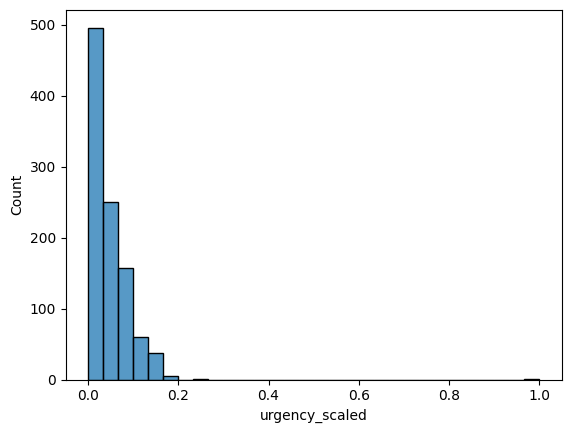

In [37]:
sns.histplot(data=df, x="urgency_scaled", bins=30)

In [38]:
df['urgency_label'] = pd.qcut(
    df['urgency_score'], 
    q=[0, 0.25, 0.75, 0.95, 1],  # cut points at 0%, 25%, 75%, and 100%
    labels=['low', 'medium', 'high', 'special']
)

In [39]:
df[['urgency_label','urgency_scaled', 'urgency_score', 'additional_info']].head(20)

,urgency_label,urgency_scaled,urgency_score,additional_info
0,medium,0.046154,4.5,In our school we have an Outdoors Instructor who would love the chance to develop a veg patch in her outdoor space to support our SEND students in growing and cooking their own food. The equipment and seeds provided in the giveaway would develop our students understanding of how to grow your own food but also the process of growing your own food.
1,medium,0.035897,3.5,"We are currently working on our outdoor provision. We have a large area and would love to be able to give it a full makeover! As a setting our ethos is to be nature inspired whilst using the curiosity approach with the added extras of colour etc. The children love spending time in the garden and enjoy planting and tending for the plants whilst also looking at the nature around. We have a wildlife garden which is in great need for a massive do over due to it being overgrown also - in here we have a pond, which was once home to many frogs!"
2,high,0.092308,9.0,"I would use this bundle with our SEN children, in particular the children I work with who have trauma; gardening has huge therapeutic benefits and this bundle will enable me to take the children out to the garden and enjoy the natural dopamine rush!"
3,special,0.148718,14.5,"I run outdoor learning at my school, we are in a very deprived area, in a central area of Milton Keynes in the middle of a housing estate, the school has very little. I currently pay for as much as possible. We have now got an allotment area, but really need some help with filling it!! We are trying hard to run outdoor learning sessions, as we have so many children without gardens who live in converted shipping containers and their faces when they tackle ceratin skills and plant and see things grow is beautiful. please please help us!!!"
4,medium,0.056410,5.5,"Our school is passionate about hands-on learning, and gardening is a perfect way to engage students with nature, science, and sustainability. Your gardening bundles would help us create an interactive garden space where students can grow their own fruits, vegetables, and flowers. This experience will teach responsibility, patience, and teamwork while reinforcing lessons in biology and environmental care. With your support, we could expand our garden with tools, seeds, and educational resources, making gardening accessible for all students. These bundles would inspire young minds, fostering a love for nature and healthy living while strengthening our school community."
5,medium,0.046154,4.5,"Our EYFS setting at Brocks Hill fosters curiosity and hands-on learning. Gardening bundles would enrich our curriculum by providing practical experiences in nature, promoting teamwork, and teaching responsibility. These bundles would support our children in understanding plant life cycles, environmental stewardship, and healthy eating habits. Your resources could help us create engaging outdoor activities, enhancing sensory development and fine motor skills. We aim to inspire young gardeners and instill a lifelong love for nature. Your support would be invaluable in nurturing our children's growth and learning. ?"
6,low,0.000000,0.0,"Today I played an April Fool's trick on my class, convincing them that we could grow marshmallows! We made posters about the process and even chose an area to grow them on! They showed great knowledge of what plants needed to grow. To make up for my trick I would love them to have some growing items for real, so they could grow some real plants from seed instead of mini marshmallows!"
7,medium,0.030769,3.0,"We are an inner city school in Sheffield where lots of our children don't have garden space, we would use this equipment to help the children understand how to care for nature, as well as the calm and tranquility nature gives to us. In addition to this it would support us in teaching our children how to have a healthy lifestyle and how to give back to our local community creating a

<Axes: xlabel='urgency_label', ylabel='count'>

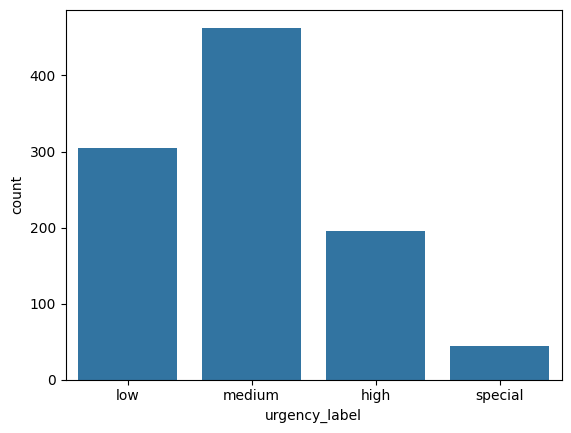

In [40]:
sns.countplot(data=df, x='urgency_label')

In [41]:
len(df[(df['urgency_label'] == 'high') | (df['urgency_label'] == 'special')])
mid_high_urg = df[(df['urgency_label'] == 'high') | (df['urgency_label'] == 'special')]
mid_high_urg[['urgency_label', 'additional_info', 'urgency_score']]

,urgency_label,additional_info,urgency_score
2,high,"I would use this bundle with our SEN children, in particular the children I work with who have trauma; gardening has huge therapeutic benefits and this bundle will enable me to take the children out to the garden and enjoy the natural dopamine rush!",9.0
3,special,"I run outdoor learning at my school, we are in a very deprived area, in a central area of Milton Keynes in the middle of a housing estate, the school has very little. I currently pay for as much as possible. We have now got an allotment area, but really need some help with filling it!! We are trying hard to run outdoor learning sessions, as we have so many children without gardens who live in converted shipping containers and their faces when they tackle ceratin skills and plant and see things grow is beautiful. please please help us!!!",14.5
15,high,"Our inner city London school serves a diverse community where many children have limited access to nature. We believe in the power of biophilia, connecting children with the outdoors to support mental well-being. This support would help us create enriching outdoor experiences, fostering a love for nature while improving mental health. Weâ€™d engage parents and the wider community, ensuring children take pride in their environment. Through gardening, outdoor learning, and community projects, weâ€™d inspire children to make healthier choices, care for green spaces, and develop lifelong respect for nature. This initiative would empower our pupils and strengthen community ties.",8.5
20,high,"To win the money or the gardening bundle would be amazing, to support all our children to access the gardening projects around nursery, looking after and caring for things. The children will be able to see the insects that are drawn into the planting. We are a very outdoors nursery but being able to have equipment and resources to enhance children's play would just be amazing. Fingers crossed. Thankyou for the opportunity to enter. The Scallywags Family x",8.0
21,high,"The gardening bundle will support children in Nursery and Reception in our setting. Many children live in flats and do not have access to their own outside space so we do as much gardening and planting that we can, to provide children with enrichment and an understanding of the world. Gardening is also fantastic to support children's physical development, communication and language and is an inclusive activity for all the children in our setting. Being outdoor and learning about nature helps to support children's mental health so we have set up a gardening club for the older children in our setting which is supported by parent helpers. The gardening club members can also support our younger children and teach them how to grow their own flowers and vegetables, explore the outside environment and have fun.",7.0
...,...,...,...
990,special,"We are a community primary school situated at the heart of a very deprived area. Our families face the daily grind of deprivation and poverty which as a consequence means thier children do too. The school has a well attended, passionatly delivered, Green Club, it has vision and hope but little resources, please empower and support this wonderful club to grow and flourish.",13.0
997,high,"We have a catholic school in a deprived area of London. Many of our students are from low income single parent households who are privileged with our school grounds including green space but this space needs development. I would love to use this to set up a gardening club and begin growing vegetables that children can take home or use in a cooking club further along to provide them with life skills to provide for and nurture themselves. Much of what I provide comes from my own pocket as I'm sure we all do, to give these children experiences they may not otherwise have.",8.5
1002,high,"We have climate change and the environment at our core at our school. We have fantastic Eco Warriors and very keen chil

In [44]:
low_urg = df[df['urgency_label'] == 'low']

low_urg[['additional_info']].head(10)

,additional_info
6,"Today I played an April Fool's trick on my class, convincing them that we could grow marshmallows! We made posters about the process and even chose an area to grow them on! They showed great knowledge of what plants needed to grow. To make up for my trick I would love them to have some growing items for real, so they could grow some real plants from seed instead of mini marshmallows!"
8,"We have quite a high level of ALN children in our reception class and we are trying to get resources to develop a sensory garden, so it would come in so handy to help develop plants and flowers which were tactile. Id also like to develop their physical skills, communication skills and links with nature by having resources to plant and grow their own plants and food. It would be so beneficial for them and following classes."
11,"Our school is wanting to set up a gardening club and Eco club which will run together. As a small school in a rural setting, this is important for us to encourage pupils to take care of the environment they live in and to develop their life skills through growing vegetable and understanding how to work as a team as well as all the other numerous lessons they will earn from these experiences. We will also encourage pupils to teach other children the skills they have acquired and promote the importance of everyone being involved in these projects this for the future of our world."
13,"We are starting a Nurture provision in September and part of that, we would love to build the children's love for nature by growing fruits and vegetables and expanding that love into cooking and baking."
28,"We are developing an allotment to teach the children about growing food, conservation of water and the importance of nutrients in our diet. The whole school is taking part, from nursery to year 6."
31,"This would be fantastic for our school as it would teach our children how to develop their mindset through gardening showing them how endless growing of fruit,vegetables,plants and flowers."
32,"The garden bundle would give us the building blocks to ignite our children's love of the outdoors, nurture our children's love of nature , and plant the seeds of learning."
33,Our setting is small but amazing . We have no outdoor space for children so we go on outings everyday. More resources and extra money to spend on outdoor equipment would be great. This would mean we could take more resources to the parks for the children to engage and enjoy the outdoors which is so important for their development
35,"As a school, we are aiming to be more sustainable and eco-friendly. Starting in early years, we teach the children how plants and food grow. In every class, we have a plant that we are responsible for looking after. We grow different foods and vegetables that the children can then taste."
40,"Our gardening club is brilliant, but we never have enough gloves or resources. This would allow more children to experience planting/growing/caring for the crops they plant. From seed to full blossom. Our school is an Infant school and many of our children live in flats or small houses without gardens. Gardening club is often their only experience of growing things from scratch and nature. The crops grown are used for snack/cooking and brightening up the school, the children love to see the whole process and are really proud when the know that they have grown the food everyone is eating."
